In [1]:
import math
import numpy as np
import gym
import copy
import random
from scipy import signal, interpolate
import fieldii
import matplotlib.pyplot as plt

# TODO polaczyc z UsEnv w jedna calosc i przetestowac (ile czasu bedzie generowana jedna klatka)

In [2]:
class Imaging:
    def __init__(
        self,
        c, fs, image_width,
        image_grid, grid_step,
        median_filter_size,
        no_lines,
        dr_threshold
    ):
        self.c = c
        self.fs = fs
        self.image_width = image_width
        self.image_grid = image_grid
        self.grid_step = grid_step
        self.median_filter_size = median_filter_size
        self.no_lines = no_lines
        self.dr_threshold = dr_threshold

    def _interp(self, data):
        # interpolate data along axis=1
        input_xs = np.arange(0, data.shape[1])*(self.image_width/data.shape[1])
        input_zs = np.arange(0, data.shape[0])*(self.c/(2*self.fs))

        output_xs = np.arange(self.image_grid[0], step=self.grid_step)
        output_zs = np.arange(self.image_grid[1], step=self.grid_step)
        return interpolate.interp2d(input_xs, input_zs, data, kind="cubic")(output_xs, output_zs)

    def _detect_envelope(self, data):
        return np.abs(signal.hilbert(data, axis=0))

    def _adjust_dynamic_range(self, data, dr=-60):
        nonzero_idx = data != 0
        data = 20*np.log10(np.abs(data)/np.max((np.abs(data[nonzero_idx]))))
        return np.clip(data, dr, 0)

    def create_bmode(self, rf):
        data = self._detect_envelope(rf)
        data = self._adjust_dynamic_range(data, dr=self.dr_threshold)
        data = self._interp(data)
        data = signal.medfilt(data, kernel_size=5)
        return data

In [3]:
field_session = fieldii.Field2(no_workers=8)

MATLAB function 'simulate_linear_array.m' started...
MATLAB function 'simulate_linear_array.m' started...
MATLAB function 'simulate_linear_array.m' started...
MATLAB function 'simulate_linear_array.m' started...
MATLAB function 'simulate_linear_array.m' started...
MATLAB function 'simulate_linear_array.m' started...
MATLAB function 'simulate_linear_array.m' started...
MATLAB function 'simulate_linear_array.m' started...
Started 8 MATLAB worker(s).
Waiting 15s till all MATLAB processes will be available...
Checking state of the workers...
Everything is ok.


In [4]:
# Example cyst phantom with a single object.
# Points uniformly distributed in space (U[-25, 25] x U[-25, 25] x U[30, 80])

fs = 100e6 # sampling frequency [Hz]
speed_of_sound = 1540 # speed of sound [m/s]
n = 20000 # number of scatterers
x_size = 40/1000 # [m]
y_size = 40/1000 # [m]
z_size = 90/1000 # [m]
z_start = 0/1000 # [m]

xs = (np.random.rand(n, 1)-0.5)*x_size
ys = (np.random.rand(n, 1)-0.5)*y_size 
zs = np.random.rand(n, 1)*z_size+z_start
points = np.concatenate((xs, ys, zs), axis=1)

# Example1: cyst phantom
r = 20/1000
cyst_amplitude = 1000
cyst_center = np.array([0,0,60/1000])
amps = np.random.randn(n, 1)*100

# determine, which points belong to the cyst
cyst_indices = np.sum(np.power(points-cyst_center, 2), axis=1) < r*r
print(np.sum(cyst_indices))
cyst_points = points[cyst_indices, :]
# change amplitude of the cyst points
amps[cyst_indices] = cyst_amplitude*amps[cyst_indices]
rf_array, t_start = field_session.simulate_linear_array(
    points, amps, sampling_frequency=fs, no_lines=64)

4652
Simulating linear array in Field II...


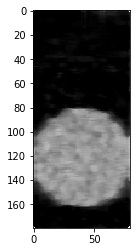

In [5]:
imaging = Imaging(
    c=1540, 
    fs=100e6, 
    image_width=40/1000, 
    image_grid=(40/1000, 90/1000), 
    grid_step=0.5/1000, 
    no_lines=64, 
    median_filter_size=5,
    dr_threshold=-100
)
img = imaging.create_bmode(rf_array)
plt.imshow(img, cmap='gray')

In [202]:
probe = Probe(
    pos=np.array([0,0,0]), # [x, y, z]
    angle=0, 
    width=40/1000, 
    height=10/1000, 
    focal_depth=60/1000
)
phantom = Phantom(
    objects=[
        Teddy(
            belly_pos=np.array([0,0,60/1000]), # pozycja brzuszka 
            scale=10/1000,                     # promien brzuszka
            dist_ahead=.9                      # odlegosc glowy od brzuszka
            ),
    ],
    x_border=(-60/1000, 60/1000), # szerokosc fantomu OX
    y_border=(-60/1000, 60/1000), # szerokosc fantomu OY
    z_border=(0, 90/1000),        # glebokosc fantomu OZ
    n_scatterers=int(4e4),        # calkowita liczba rozpraszaczy
    n_bck_scatterers=int(2e3)     # zredukowana liczba rozpraszaczy tla (poza obszarem obiektow 'objects')
) 

imaging = Imaging(
    c=1540, 
    fs=100e6, 
    image_width=40/1000, 
    image_grid=(40/1000, 90/1000), 
    grid_step=0.5/1000, 
    no_lines=64, 
    median_filter_size=5,
    dr_threshold=-100
)

env = UsPhantomEnv(phantom=phantom, probe=probe, imaging=imaging)

Waiting for MATLAB to execute 'simulate_linear_array.m' function...
... done!


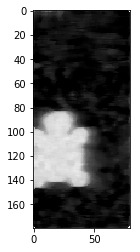

In [203]:
ob, reward, episode_over, _ = env.step(action=[1, 0, 0])
plt.imshow(ob, cmap='gray')
plt.show()

In [6]:
field_session._cleanup()

Waiting for MATLAB to execute 'simulate_linear_array.m' function...
... done!


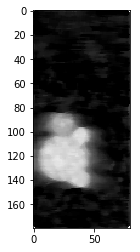

In [204]:
ob, reward, episode_over, _ = env.step(action=[0, 0, 4])
plt.imshow(ob, cmap='gray')
plt.show()

In [ ]:
def plot_from_angle(ax, elev, azim):
    ax.set_xlabel("$X$")
    ax.set_ylabel("$Y$")
    ax.set_zlabel("$Z$")
    ax.set_xlim([-20/1000, 20/1000])
    ax.set_ylim([-20/1000, 20/1000])
    ax.set_zlim([0/1000, 90/1000])
    ax.invert_zaxis()
    ax.view_init(elev, azim)
    ted.plot_mesh(ax)


points, amps, pht = phantom.get_points(pr)
print(pht.objects[0].to_string())
print("Number of points: %d" % points.shape[0])
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')
ax.invert_zaxis()
pht.plot_mesh(ax)

space_slice = []
slice_amps = []
for i in range(points.shape[0]):
    row = points[i, :]
    if int(round(row[1]*100)) == 0:# around y = 0
        slice_amps.append(amps[i][0])
        space_slice.append((row[0], row[2]))
x, y = zip(*space_slice)
plt.figure(figsize=(5, 9))
plt.scatter(x, y, s=10, c=slice_amps, cmap='plasma')
plt.colorbar()

Teddy:
belly: pos=[0.   0.   0.06], r=0.01,
head: pos=[0.    0.    0.046], r=0.005,
paw: pos=[0.00872098 0.         0.05127902], r=0.0033333333333333335
paw: pos=[0.00872098 0.         0.06872098], r=0.0033333333333333335
paw: pos=[-0.00872098  0.          0.06872098], r=0.0033333333333333335
paw: pos=[-0.00872098  0.          0.05127902], r=0.0033333333333333335



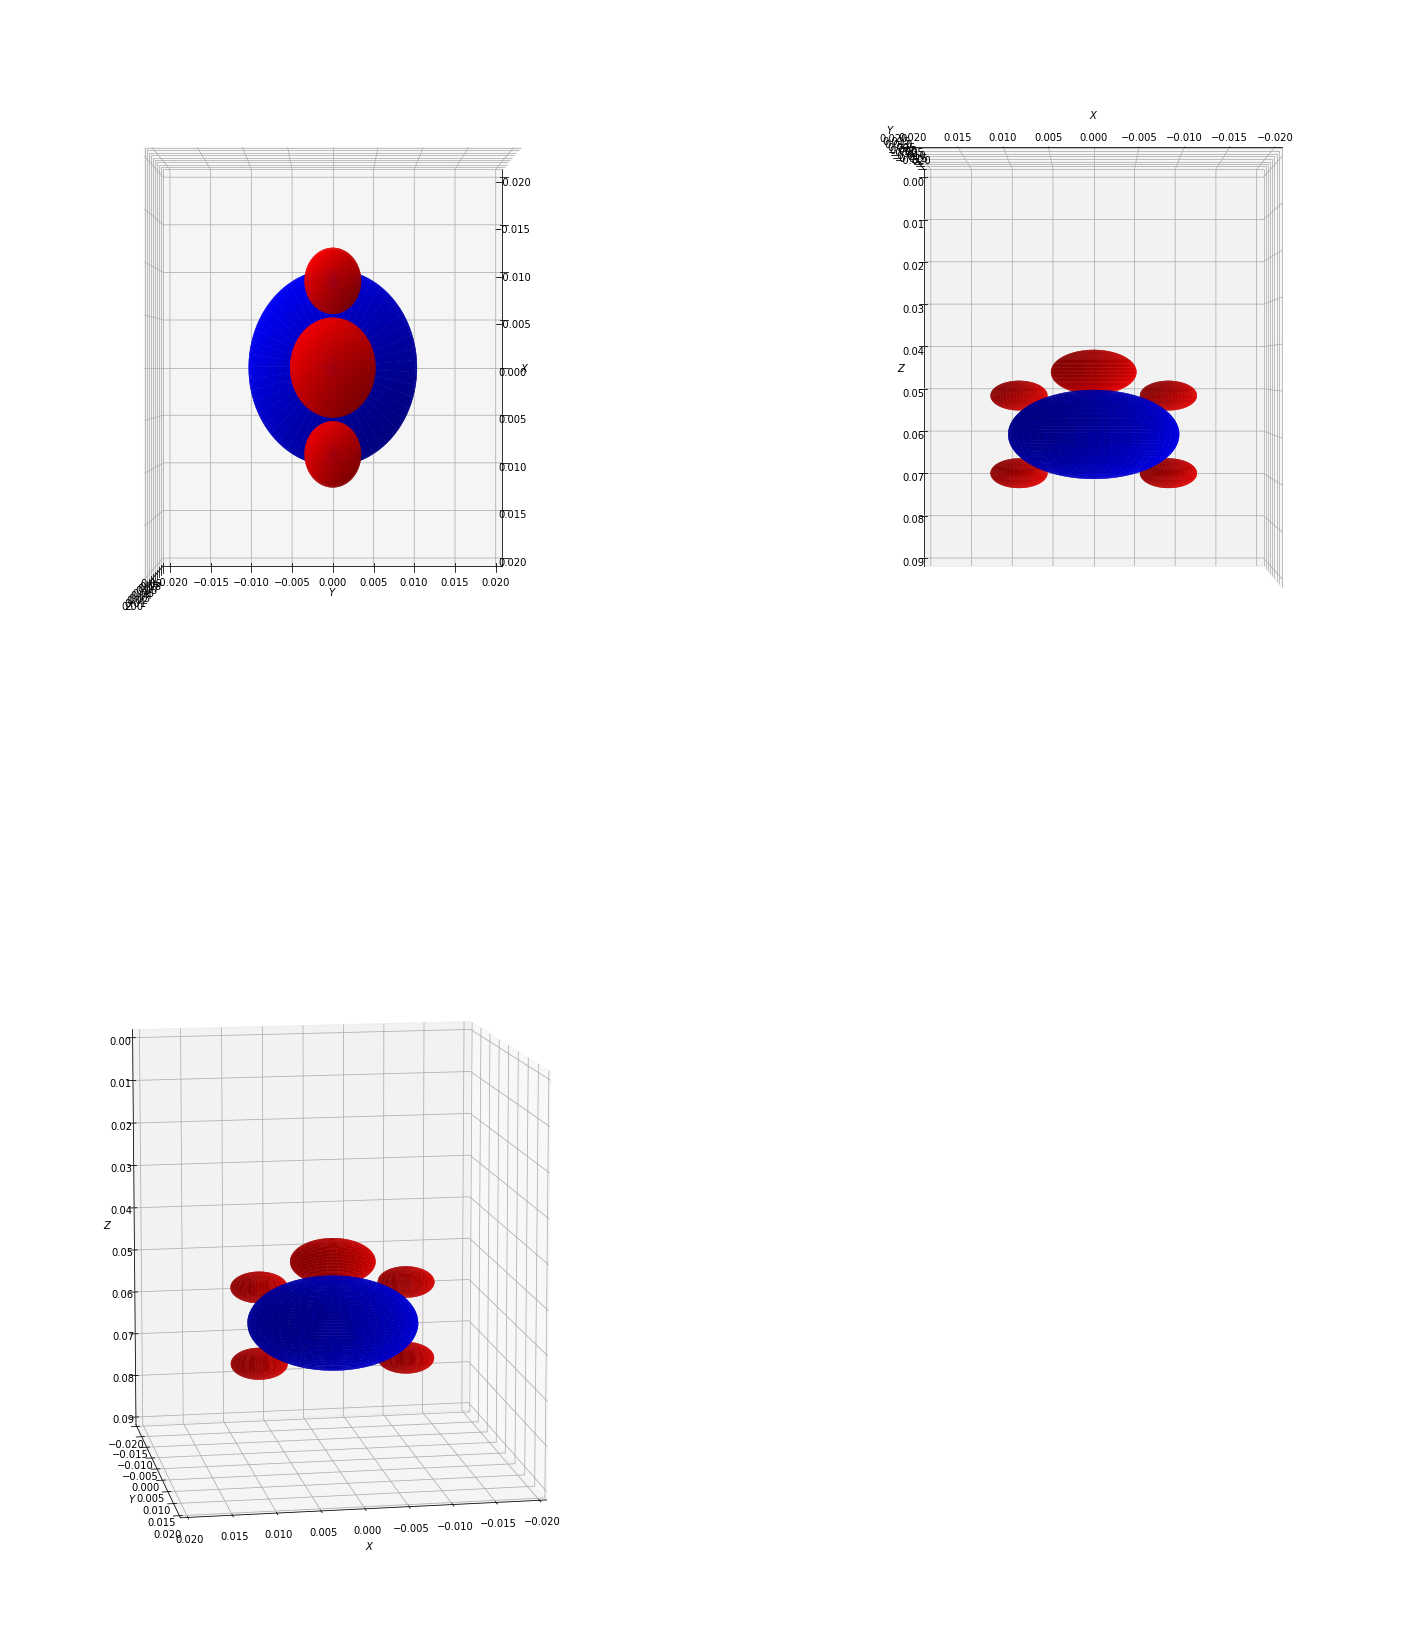

In [96]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Create one teddy bear and rotate it.
r = 10/1000
ted = Teddy(belly_pos=np.array([0,0,60/1000]), scale=r, dist_ahead=.9)
print(ted.to_string())
ted = ted.rotate_xy(axis_pos=np.array([0,0,0]), angle=0)



fig = plt.figure()
fig.set_size_inches(25, 30)
ax = fig.add_subplot(221, projection='3d')
plot_from_angle(ax, 90, 0)
ax = fig.add_subplot(222, projection='3d')
plot_from_angle(ax, 0, 90)
ax = fig.add_subplot(223, projection='3d')
plot_from_angle(ax, 10, 80)
plt.show()

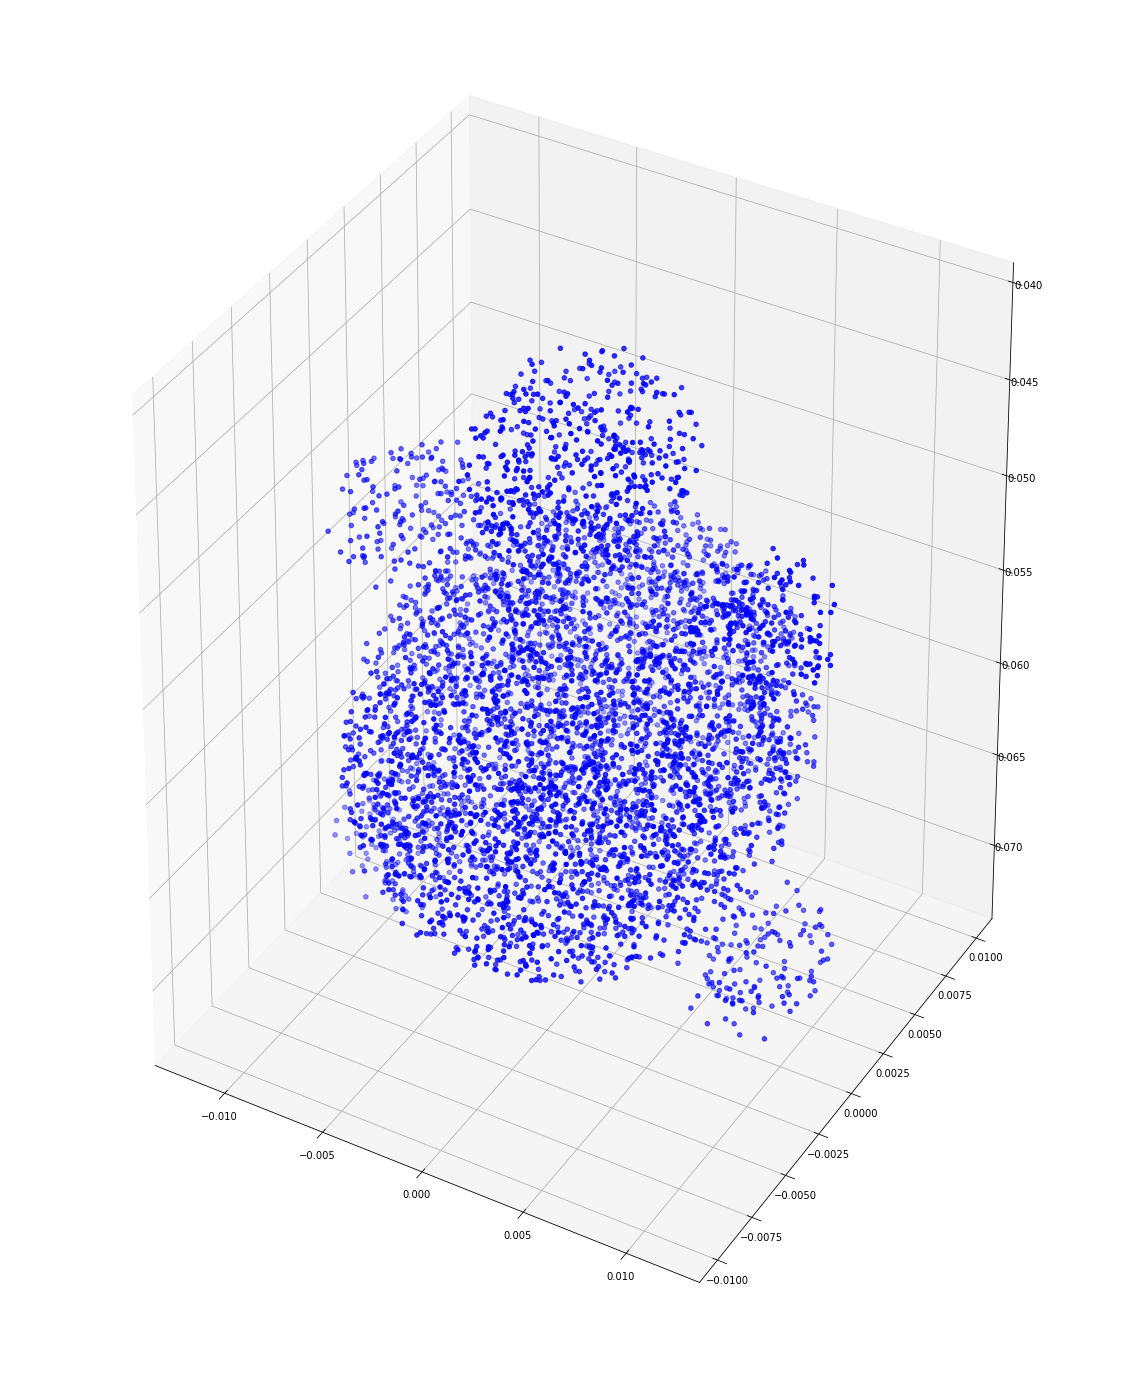

In [97]:
# scattering phantom
n = 100000 # number of scatterers
x_size = 40/1000 # [m]
y_size = 40/1000 # [m]
z_size = 60/1000 # [m] 
z_start = 30/1000 # [m]
xs = (np.random.rand(n, 1)-0.5)*x_size
ys = (np.random.rand(n, 1)-0.5)*y_size 
zs = np.random.rand(n, 1)*z_size+z_start
points = np.concatenate((xs, ys, zs), axis=1)
points_idx = ted.contains(points)
teddy_points = points[points_idx]
# TODO neighborhood_points - increase amplitude
background_points = points[np.logical_not(points_idx)]
background_sample = random.sample(list(range(background_points.shape[0])), 2000)
background_points = background_points[background_sample]
points = np.concatenate((teddy_points, background_points))
points_idx = np.array([True]*teddy_points.shape[0]+[False]*background_points.shape[0])

fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(111, projection='3d')
ax.invert_zaxis()

ax.scatter(teddy_points[:, 0], teddy_points[:, 1], teddy_points[:, 2], c='b', marker='o')
plt.show()

In [98]:
from scipy import signal, interpolate

c = 1540   # [m/s]
fs = 100e6 # [Hz]
image_width = 40/1000
image_grid = (40/1000, 90/1000)
step = 0.5/1000

def interp(data, output_grid):
    # interpolate data along axis=1
    input_xs = np.arange(0, data.shape[1])*(image_width/data.shape[1])
    input_zs = np.arange(0, data.shape[0])*(c/(2*fs))

    output_xs = np.arange(image_grid[0], step=step)
    output_zs = np.arange(image_grid[1], step=step)
    return interpolate.interp2d(input_xs, input_zs, data, kind="cubic")(output_xs, output_zs)


def decimate(rf, dec_factor):
    """Decimates rf matrix through 0 axis, with given decimation factor."""
    return rf[np.arange(0, rf.shape[0], dec_factor), :]


def detect_envelope(data):
    return np.abs(signal.hilbert(data, axis=0))

def adjust_dynamic_range(data, dr=-60):
    nonzero_idx = data != 0
    data = 20*np.log10(np.abs(data)/np.max((np.abs(data[nonzero_idx]))))
    return np.clip(data, dr, 0)


def postprocess_rf(rf, dr=-60, dec_factor=1):
    return interp(
        adjust_dynamic_range(
            decimate(
                detect_envelope(rf), dec_factor), 
            dr=dr), 
        dec_factor)

In [99]:
import fieldii
fs = 100e6 # sampling frequency [Hz]
speed_of_sound = 1540 # speed of sound [m/s]

amps = np.random.randn(points.shape[0], 1)*100
amps[points_idx] = 1000*amps[points_idx]
# 4. Prepare RF array
rf_array, t_start = fieldii.simulate_linear_array(
    points, amps, sampling_frequency=fs, no_lines=64, number_of_workers=8, z_focus=60/1000)

Waiting for MATLAB to execute 'simulate_linear_array.m' function...
... done!


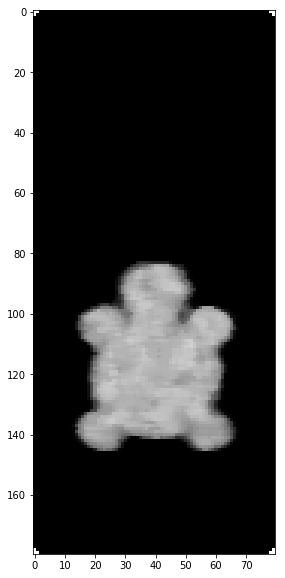

In [100]:
import scipy.signal as signal
# reconstruct image
plt.figure(figsize=(7, 10))
img = postprocess_rf(rf_array, dr=-50)
img = signal.medfilt(img, kernel_size=5)
plt.imshow(img, cmap='gray')
plt.show()